First mount your drive by clicking on 'Mount Drive' button on the left


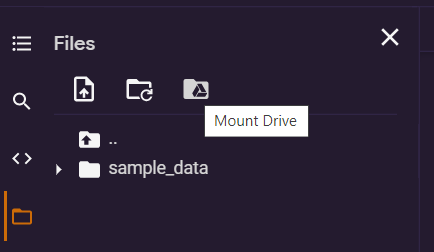

In [4]:
!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

Cloning into 'facenet_pytorch'...
remote: Enumerating objects: 1235, done.
remote: Total 1235 (delta 0), reused 0 (delta 0), pack-reused 1235
Receiving objects: 100% (1235/1235), 22.87 MiB | 45.64 MiB/s, done.
Resolving deltas: 100% (602/602), done.


In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import os, time, cv2, torch
from facenet_pytorch import MTCNN, InceptionResnetV1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


### Webcam access + display

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='snapshot.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const authButton = document.createElement('button');
            authButton.textContent = 'Who is this?';
            div.appendChild(authButton);
            
            const rememberButton = document.createElement('button');
            rememberButton.textContent = 'Remember me';
            div.appendChild(rememberButton);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            //0 for remembering new faces, 1 for authentication
            var action = '';

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for button to be clicked.
            await new Promise((resolve) => {
                authButton.onclick = function(event) {
                    action = 'authentication';
                    resolve();
              };
                rememberButton.onclick = function(event) {
                    action = 'remember';
                    resolve();
          }
          })

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          
          return [canvas.toDataURL('image/jpeg', quality), action];
        }
    ''')
    display(js)
    data, action = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    return filename, action

### DATA_PATH = path to drive folder where we store face tensors

Leave this unchanged unless an error is raised

In [7]:
DATA_PATH = '/content/drive/Shared drives/FaceID-AIClub/facedata/'

### Utility functions

In [8]:
def L2dist(a, b):
    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()
    return np.dot(a-b, (a-b).T)

In [9]:
def identity(faceTensor, dataset):
    for people in dataset:
        if L2dist(faceTensor, dataset[people])**2 <= 1.1:
            return people
    return "Unknown"

In [10]:
def load_data(path):
    data = dict()
    for faceTensor in os.listdir(path):
        data[faceTensor[:-3]] = torch.load(path + faceTensor)
    return data

### Call pre-trained models (MTCNN + FaceNet on InceptionResnet)

In [11]:
# Calls pretrained model instances
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

data = load_data(DATA_PATH)

### Run authentication/data addition T times

In [12]:
T = 10

In [13]:
for i in range(T):
    filename, action = take_photo()
    '''
    # Show the image which was just taken.
    display(IPython.display.Image(filename))
    '''
    img = Image.open(filename)
    # Detection (takes largest face)
    try:
        face = mtcnn(img)
    except:
        print("No faces found haa")
        continue
    face = face.to(device)
    # Calculate embedding (unsqueeze to add batch dimension)
    embedding = resnet(face.unsqueeze(0))
    # Compare captured face to existing data to identify the person
    if action == 'authentication':
        info = identity(embedding, data)
        print(str(i + 1) + ". " + info)
    if action == 'remember':
        print("What's your name? ")
        name = input()
        if name in data:
            print("This person already exists")
            continue
        data[name] = embedding
        torch.save(embedding, DATA_PATH + name + ".pt")

<IPython.core.display.Javascript object>

1. To Duc


<IPython.core.display.Javascript object>

2. To Duc


<IPython.core.display.Javascript object>

3. To Duc


<IPython.core.display.Javascript object>

No faces found haa


<IPython.core.display.Javascript object>

What's your name? 
ALSDKJFLAKS


<IPython.core.display.Javascript object>

6. To Duc


<IPython.core.display.Javascript object>

No faces found haa


<IPython.core.display.Javascript object>

8. To Duc


<IPython.core.display.Javascript object>

What's your name? 
To Duc
This person already exists


<IPython.core.display.Javascript object>

No faces found haa
